In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tools import *

In [3]:
# load csv of tape data
tapes = get_Tapes()
tape1 = tapes[0]

Opening UoB_Set01_2025-01-02tapes.csv
Opening UoB_Set01_2025-01-03tapes.csv
Opening UoB_Set01_2025-01-06tapes.csv
Opening UoB_Set01_2025-01-07tapes.csv
Opening UoB_Set01_2025-01-08tapes.csv
Opening UoB_Set01_2025-01-09tapes.csv
Opening UoB_Set01_2025-01-10tapes.csv
Opening UoB_Set01_2025-01-13tapes.csv
Opening UoB_Set01_2025-01-14tapes.csv
Opening UoB_Set01_2025-01-15tapes.csv
Opening UoB_Set01_2025-01-16tapes.csv
Opening UoB_Set01_2025-01-17tapes.csv
Opening UoB_Set01_2025-01-20tapes.csv
Opening UoB_Set01_2025-01-21tapes.csv
Opening UoB_Set01_2025-01-22tapes.csv
Opening UoB_Set01_2025-01-23tapes.csv
Opening UoB_Set01_2025-01-24tapes.csv
Opening UoB_Set01_2025-01-27tapes.csv
Opening UoB_Set01_2025-01-28tapes.csv
Opening UoB_Set01_2025-01-29tapes.csv
Opening UoB_Set01_2025-01-30tapes.csv
Opening UoB_Set01_2025-01-31tapes.csv
Opening UoB_Set01_2025-02-03tapes.csv
Opening UoB_Set01_2025-02-04tapes.csv
Opening UoB_Set01_2025-02-05tapes.csv
Opening UoB_Set01_2025-02-06tapes.csv
Opening UoB_

In [4]:
print(tape1.head())

                         Price  Volume
combined_time                         
2025-01-02 08:00:10.881    267       1
2025-01-02 08:00:11.067    269       1
2025-01-02 08:00:11.222    267       2
2025-01-02 08:00:12.338    270       2
2025-01-02 08:00:13.733    267       3


<AxesSubplot:xlabel='combined_time'>

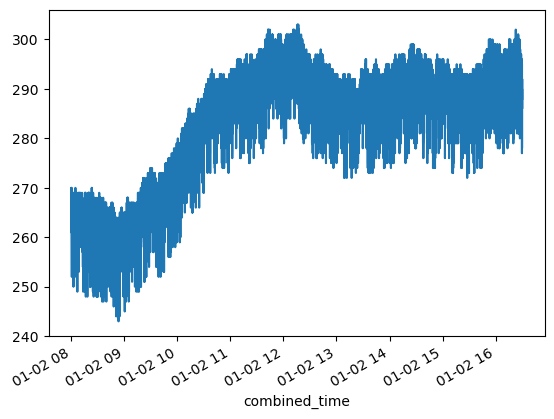

In [5]:
tape1['Price'].plot()

In [6]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(tape1['Price'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -3.338160
p-value: 0.013257


As p-value is less than 0.05 then model can be assumed stationary and no differencing is needed - this may not hold for less granular data

In [7]:
from pmdarima.arima.utils import ndiffs
ndiffs(tape1['Price'], test='adf')

0

Confirm the significant number of differencing is 0.

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

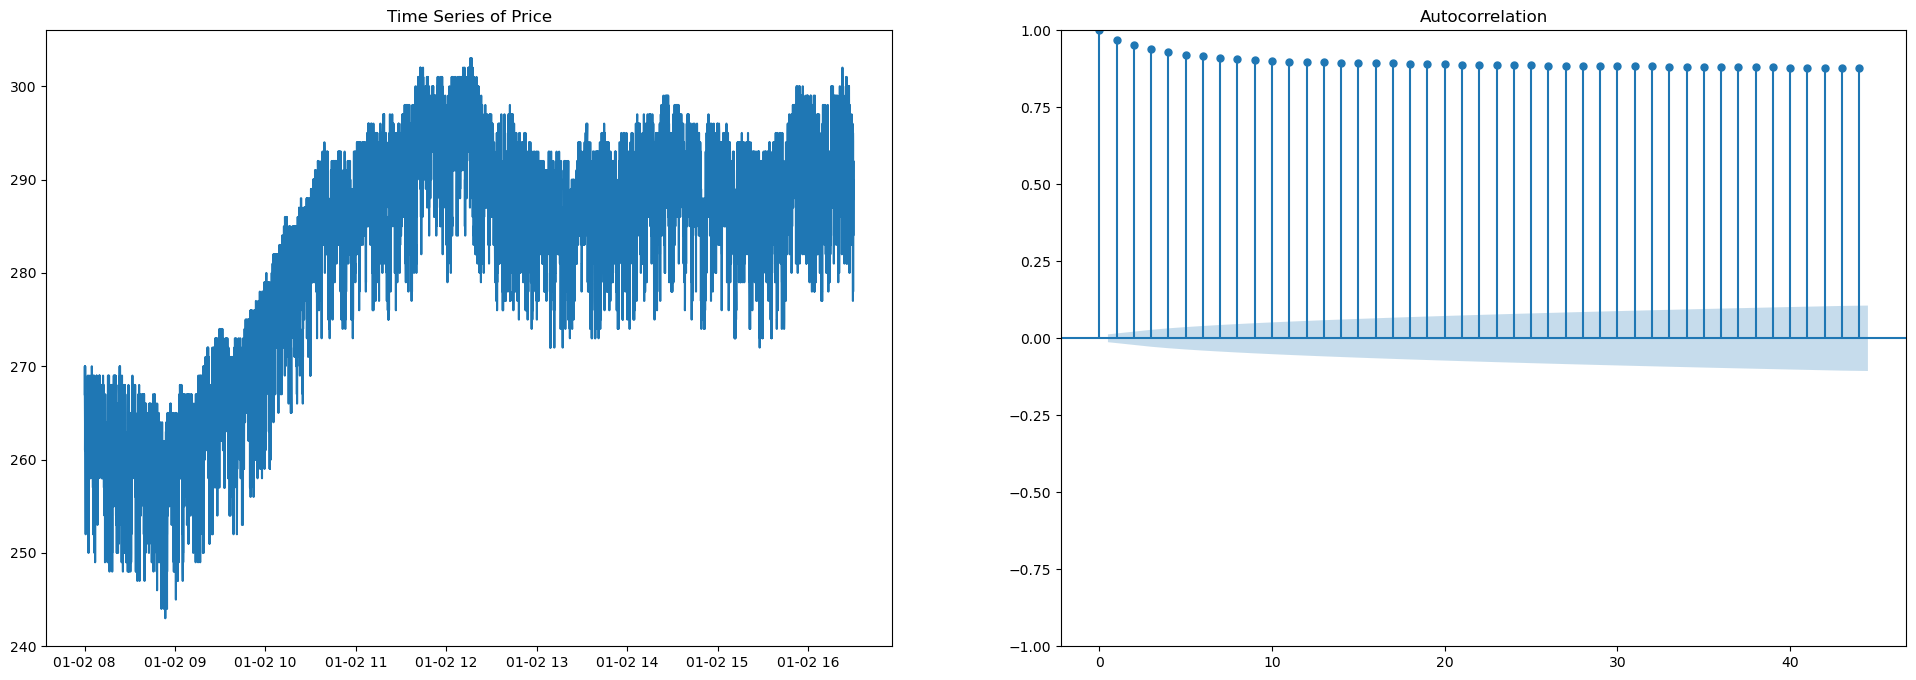

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(tape1['Price'])
ax1.set_title('Time Series of Price')
plot_acf(tape1['Price'], ax=ax2);

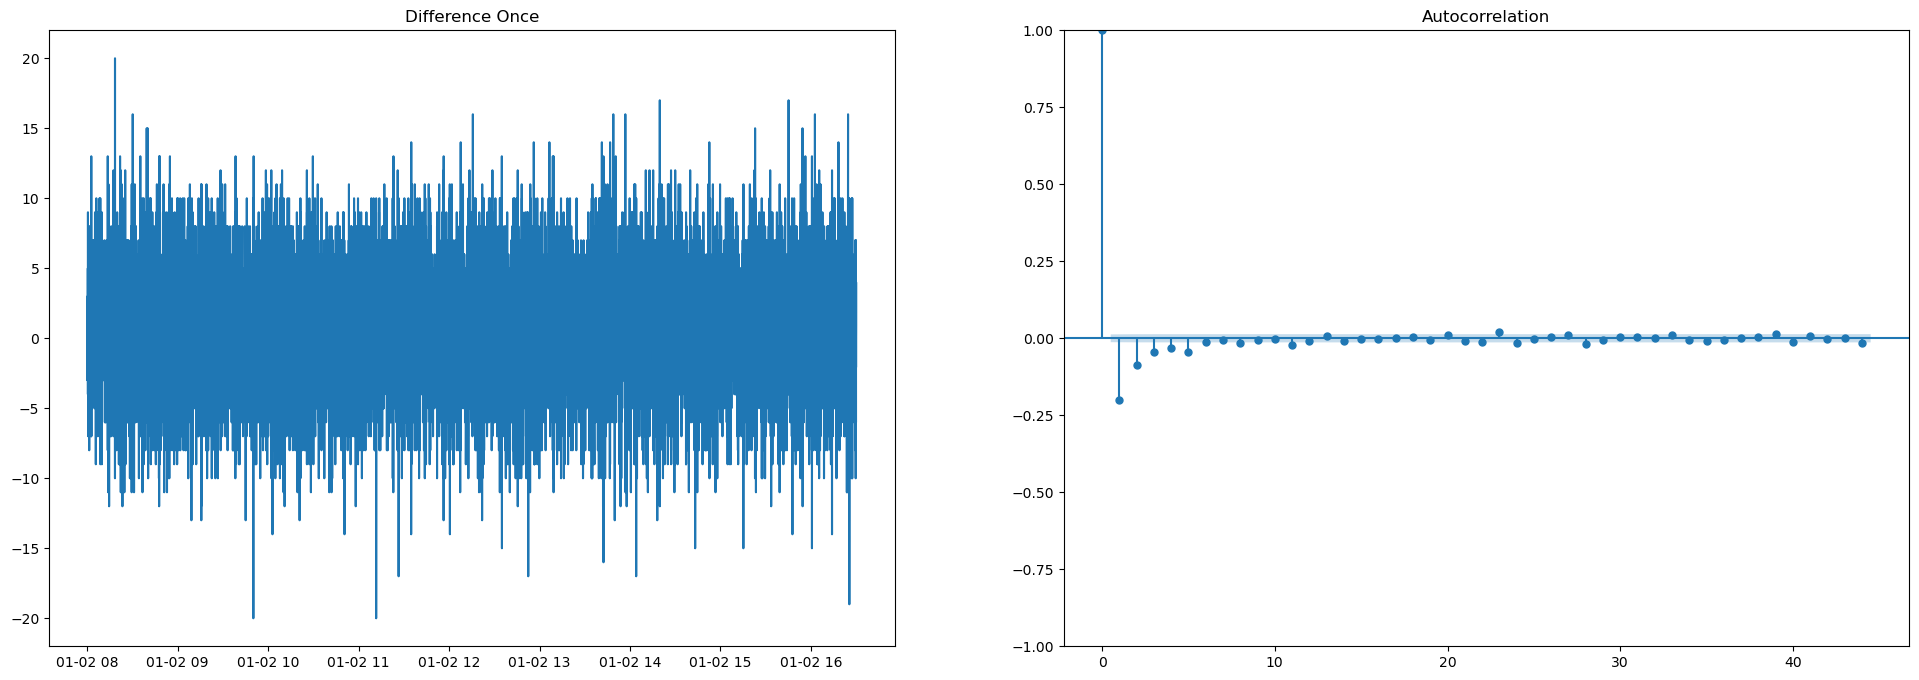

In [10]:
diff = tape1['Price'].diff().dropna()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(diff)
ax1.set_title('Difference Once')
plot_acf(diff, ax=ax2);

Differencing provides a series more celearly centred around mean 0 will be used for the further investigation despite the original data passing the ADF test. So differncing order 1 will be used in model.

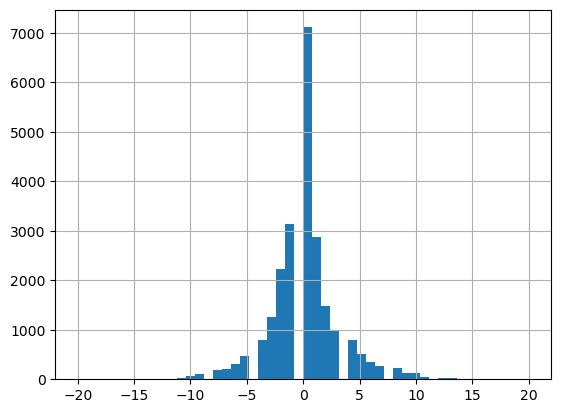

In [11]:
# histogram of differences
diff.hist(bins=50);

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


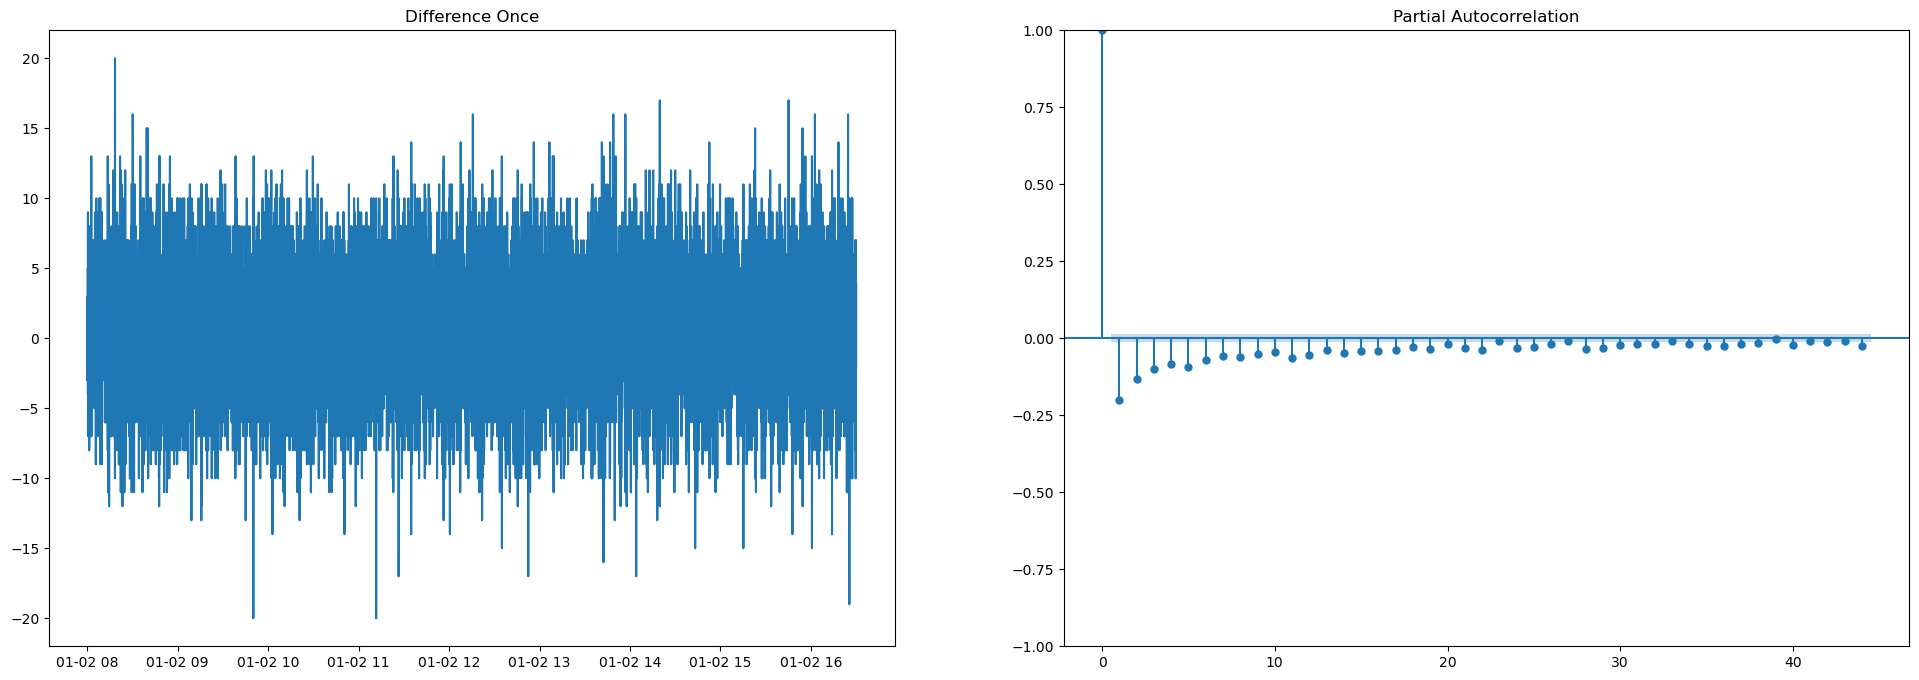

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(diff)
ax1.set_title('Difference Once')
plot_pacf(diff, ax=ax2);

Significant lags in the Auto-Regressive model which begin to die down at order 18, will take order 18 for p.

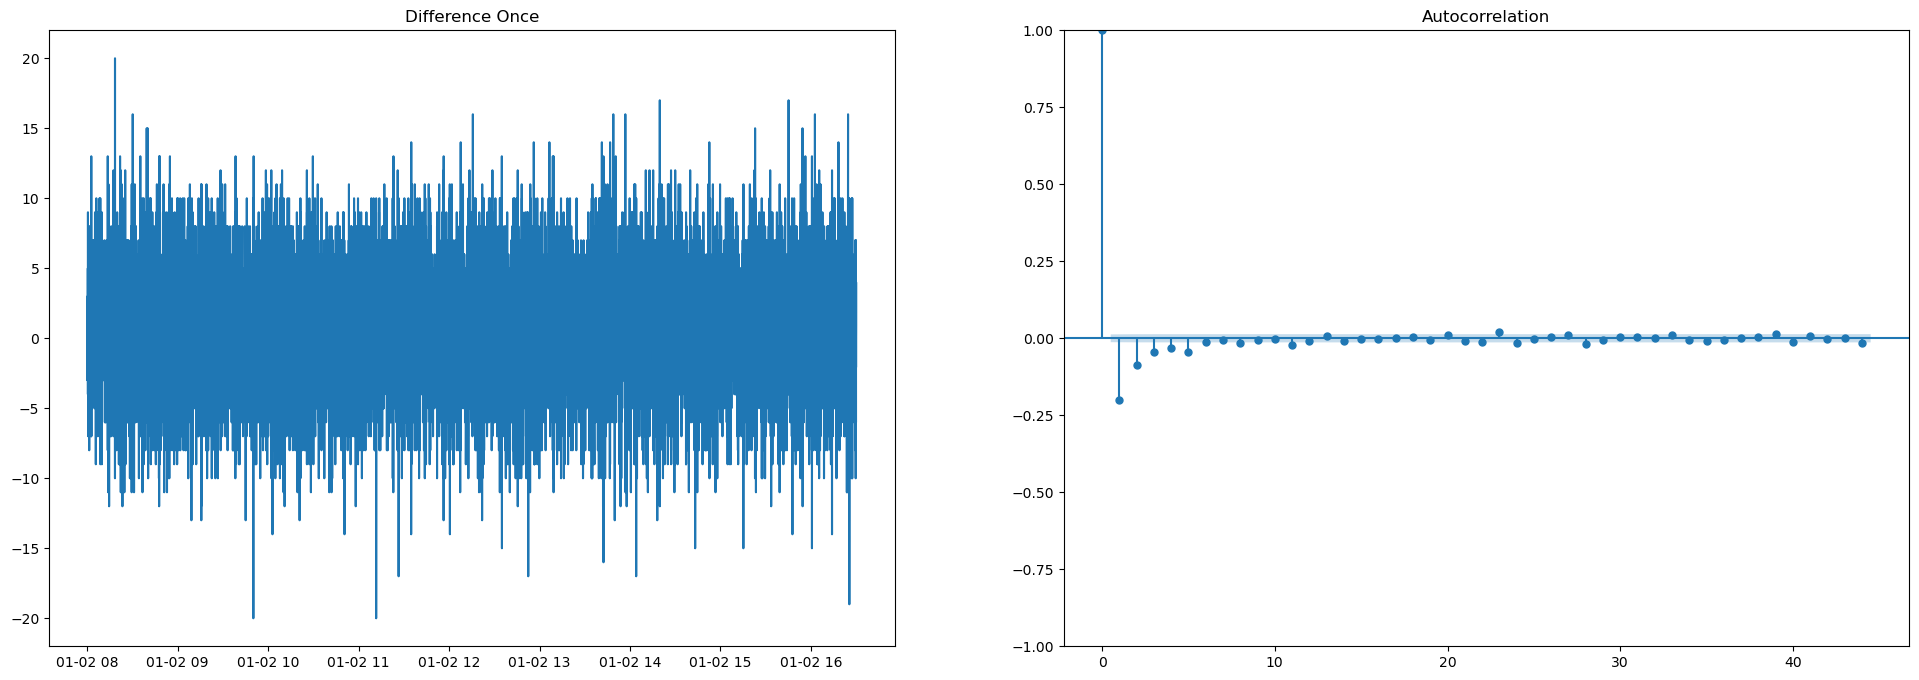

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(diff)
ax1.set_title('Difference Once')
plot_acf(diff, ax=ax2);


Significant lags in Moving Average model until lag 6, so will use order 6 for q.

In [14]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA model
model = ARIMA(tape1['Price'], order=(2,1,6))
result = model.fit()

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Using lower order model AR model to decrease run time

In [15]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                23811
Model:                 ARIMA(2, 1, 6)   Log Likelihood              -59332.834
Date:                Thu, 01 Feb 2024   AIC                         118683.668
Time:                        16:38:27   BIC                         118756.369
Sample:                             0   HQIC                        118707.254
                              - 23811                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1018      9.327     -0.011      0.991     -18.382      18.178
ar.L2          0.8020      7.893      0.102      0.919     -14.668      16.272
ma.L1         -0.2126      9.327     -0.023      0.9

Coefficient values are too small and P values are far too high, meaning the components of the model aer not significant enough so need to increase order of AR model and test performance again.

In [16]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA model
model = ARIMA(tape1['Price'], order=(4,1,6))
result = model.fit()

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [17]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                23811
Model:                 ARIMA(4, 1, 6)   Log Likelihood              -59331.823
Date:                Thu, 01 Feb 2024   AIC                         118685.646
Time:                        16:38:52   BIC                         118774.503
Sample:                             0   HQIC                        118714.474
                              - 23811                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5516      0.148     -3.738      0.000      -0.841      -0.262
ar.L2         -0.2327      0.059     -3.946      0.000      -0.348      -0.117
ar.L3          0.2895      0.081      3.580      0.0

P values are much better in this model and coefficient values higher.

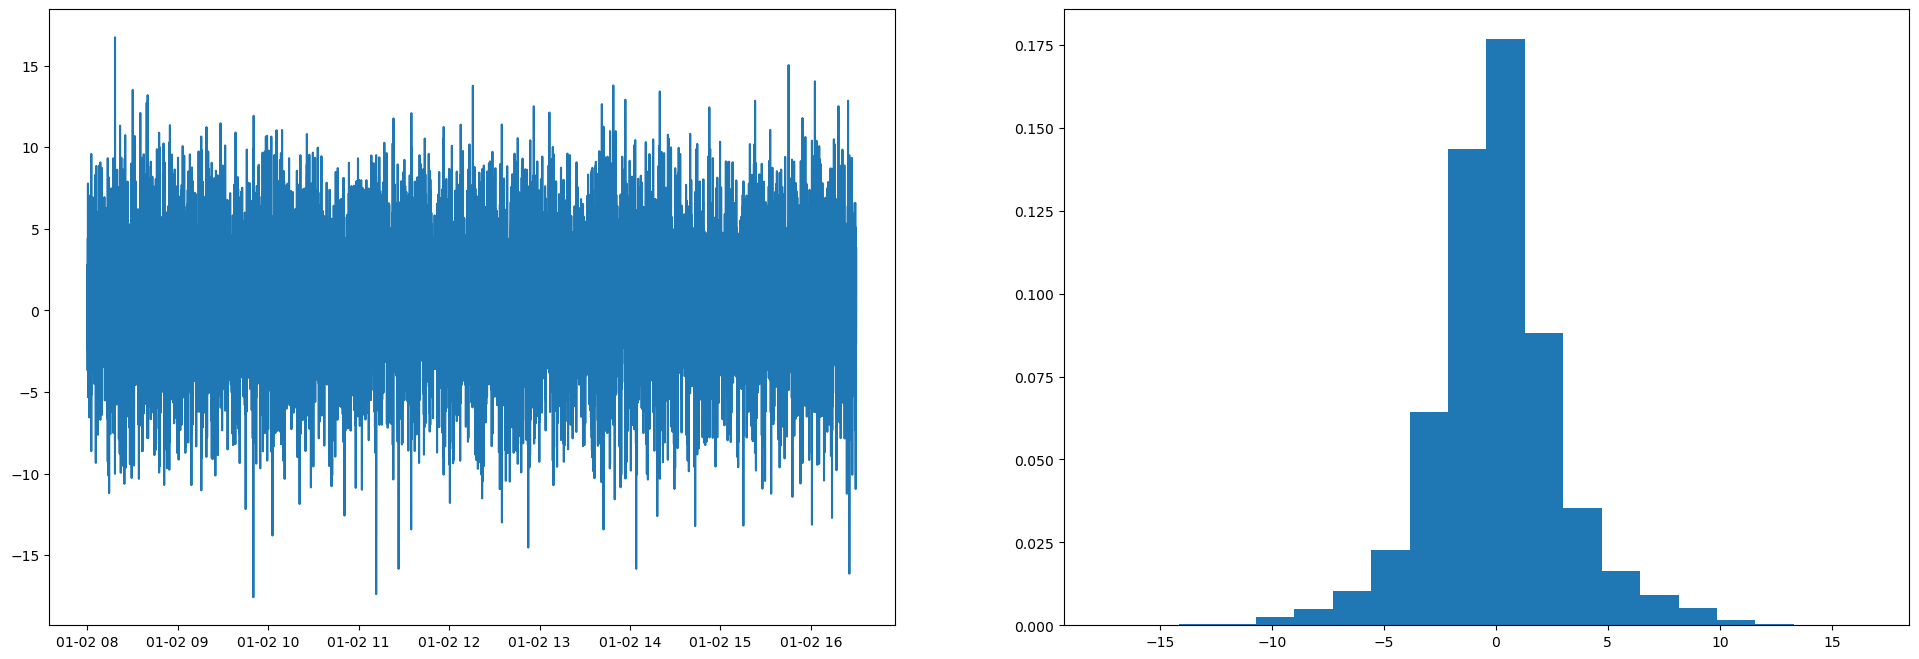

In [18]:
residuals = pd.DataFrame(result.resid)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(residuals[1:])
ax2.hist(residuals[1:], density=True, bins=20);



Text(0.5, 1.0, 'ARIMA(4,1,6) Predictions for first 100 time stamps of Tape 1')

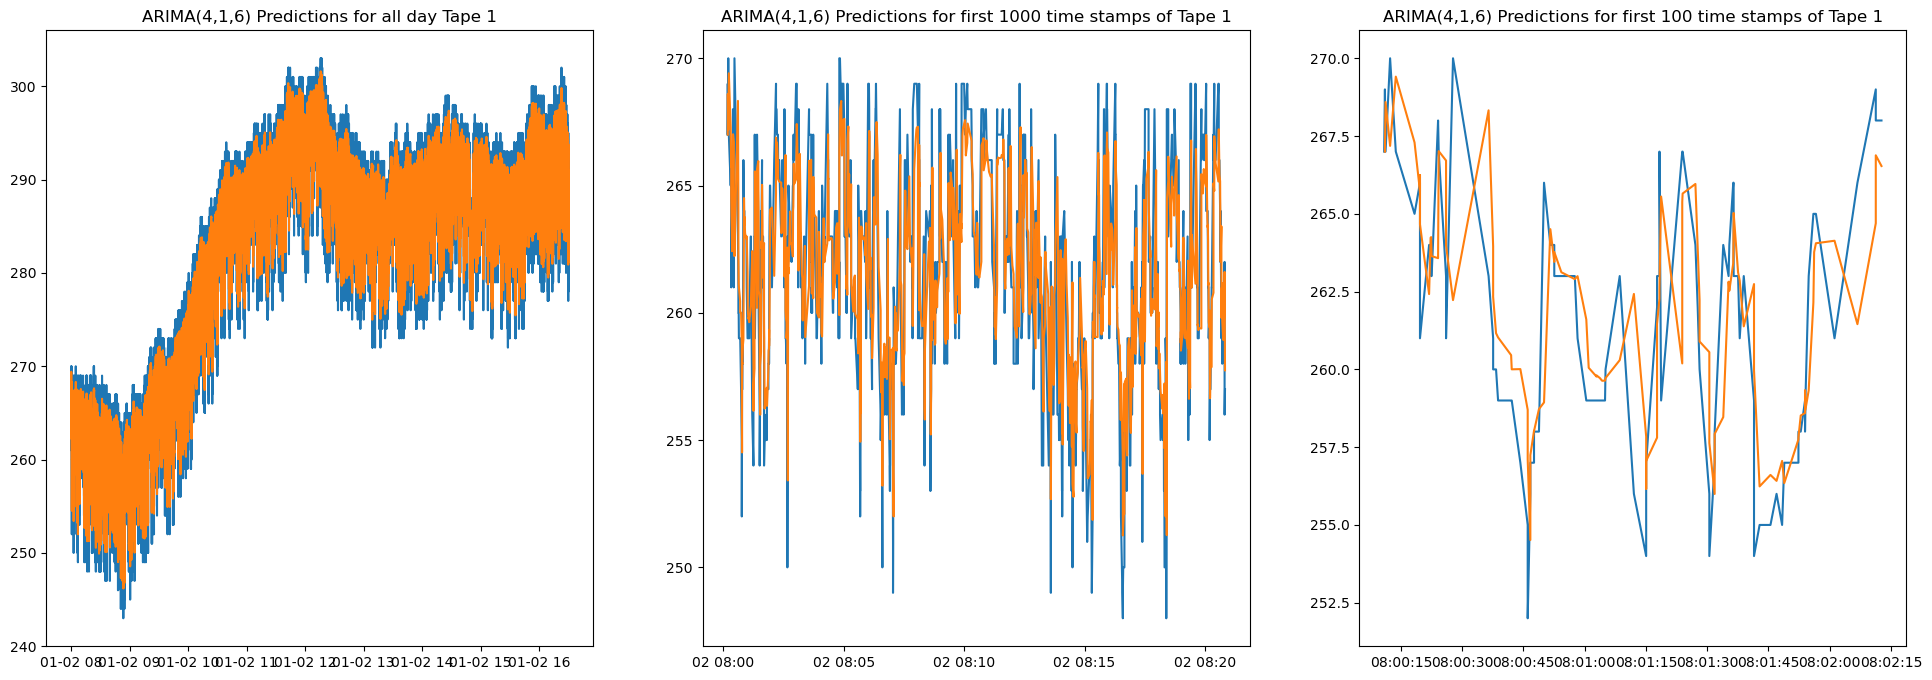

In [19]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,8))


pred = result.predict(start=0, end=len(tape1)-1)
ax1.plot(tape1['Price'])
ax1.plot(pred[1:])
ax1.set_title('ARIMA(4,1,6) Predictions for all day Tape 1')

ax2.plot(tape1['Price'][:1000])
ax2.plot(pred[1:1000])
ax2.set_title('ARIMA(4,1,6) Predictions for first 1000 time stamps of Tape 1')



ax3.plot(tape1['Price'][:100])
ax3.plot(pred[1:100]) 
ax3.set_title('ARIMA(4,1,6) Predictions for first 100 time stamps of Tape 1')

In [20]:
tape2 = tapes[1]

Use the trained model and coefficients on a completely different day and see how it performs

In [21]:
result2 = result.apply(tape2['Price'], refit=False)

result2.summary()

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                26009
Model:                 ARIMA(4, 1, 6)   Log Likelihood              -63780.662
Date:                Thu, 01 Feb 2024   AIC                         127583.324
Time:                        16:38:54   BIC                         127673.152
Sample:                             0   HQIC                        127612.344
                              - 26009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5516      0.148     -3.738      0.000      -0.841      -0.262
ar.L2         -0.2327      0.059     -3.946      0.000      -0.348      -0.117
ar.L3          0.2895      0.081      3.580      0.000       0.131       0.448
ar.L4          0.6755      0.113      5.958      0.000       0.453       0.898
ma.L1          0.2376      0.148      1.608      0.108      -0.052       0.527
ma.L2         -0.0988      0.092     -1.071      0.284      -0.280       0.082
ma.L3         -0.5351      0.079     -6.792      0.000      -0.690      -0.381
ma.L4         -0.7421      0.144     -5.152      0.000      -1.024      -0.460
ma.L5          0.1340      0.020      6.696      0.000       0.095       0.173
ma.L6          0.0452      0.009      5.141      0.000       0.028       0.062
sigma2         8.5538      0.060    143.612      0.000       8.437       8.671
===================================================================================
Ljung-Box (L1) (Q):                  12.34   Jarque-Bera (JB):             11631.81
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.27
===================================================================================

Warnings:
[1] Parameters and standard errors were estimated using a different dataset and were then applied to this dataset. Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
print('Tape 2 Error when trained on Tape 1')
print(f'MSE: {result.mse}')

Tape 2 Error when trained on Tape 1
MSE: 11.543193511418544


Text(0.5, 1.0, 'ARIMA(4,1,6) Predictions for first 100 time stamps of Tape 2')

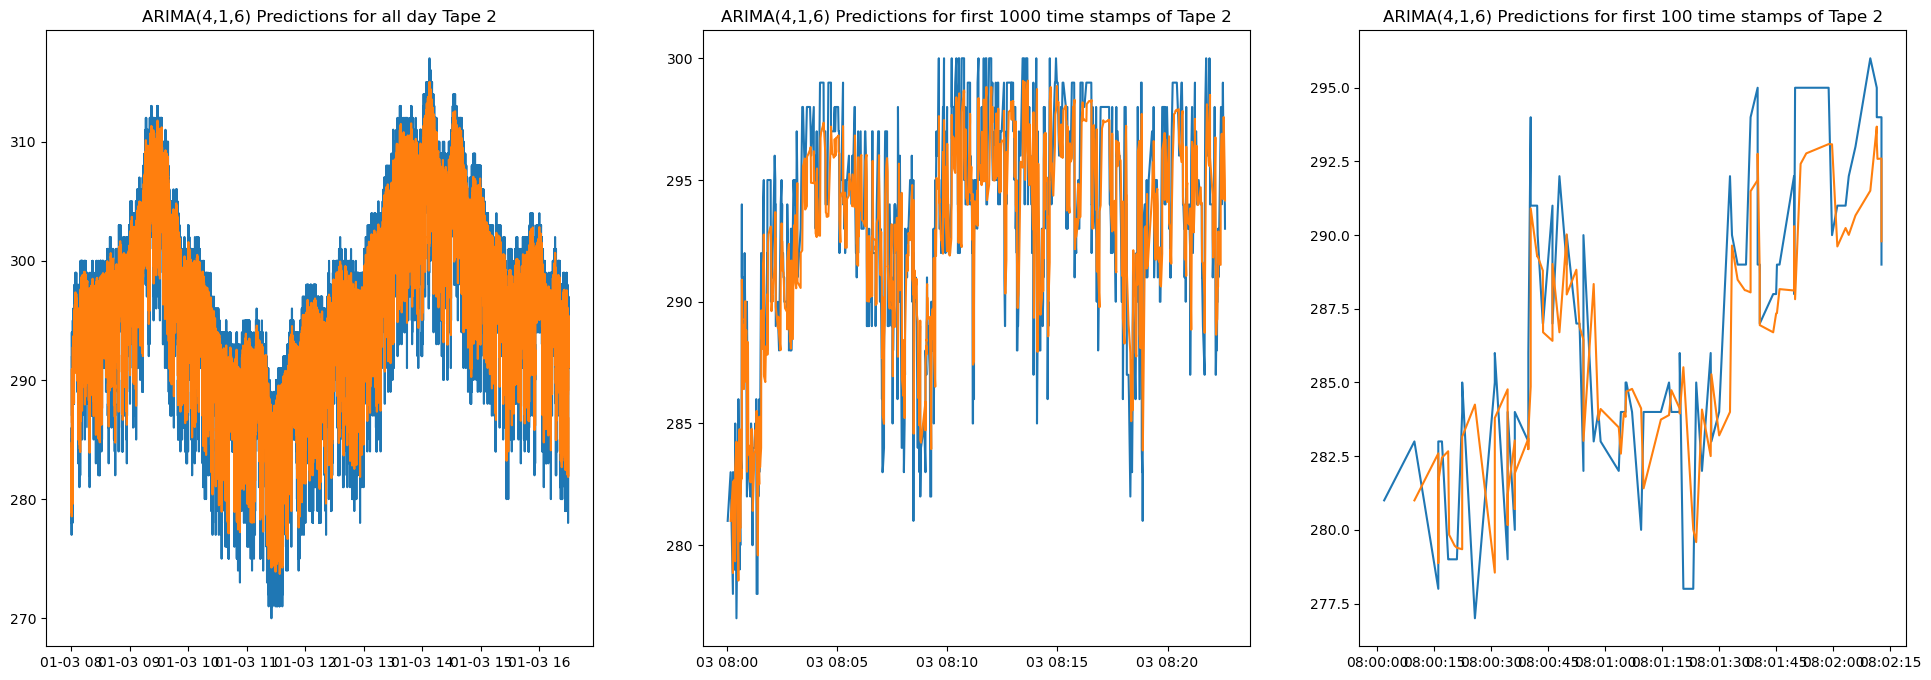

In [23]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,8))

pred2 = result2.predict(start=0, end=len(tape2)-1)
ax1.plot(tape2['Price'])
ax1.plot(pred2[1:])
ax1.set_title('ARIMA(4,1,6) Predictions for all day Tape 2')

ax2.plot(tape2['Price'][:1000])
ax2.plot(pred2[1:1000])
ax2.set_title('ARIMA(4,1,6) Predictions for first 1000 time stamps of Tape 2')

ax3.plot(tape2['Price'][:100])
ax3.plot(pred2[1:100]) 
ax3.set_title('ARIMA(4,1,6) Predictions for first 100 time stamps of Tape 2')

(array([1.49002555e-04, 4.22173906e-04, 9.68516607e-04, 2.23503832e-03,
        2.75654727e-03, 5.48826078e-03, 1.04053451e-02, 2.23007157e-02,
        6.45429401e-02, 1.67230534e-01, 1.96683373e-01, 9.74725047e-02,
        3.10670327e-02, 2.09845265e-02, 1.25658821e-02, 6.63061370e-03,
        2.23503832e-03, 9.93350367e-04, 4.96675183e-04, 2.48337592e-04]),
 array([-15.9100136 , -14.36172977, -12.81344594, -11.26516211,
         -9.71687828,  -8.16859445,  -6.62031062,  -5.07202679,
         -3.52374295,  -1.97545912,  -0.42717529,   1.12110854,
          2.66939237,   4.2176762 ,   5.76596003,   7.31424386,
          8.86252769,  10.41081153,  11.95909536,  13.50737919,
         15.05566302]),
 <BarContainer object of 20 artists>)

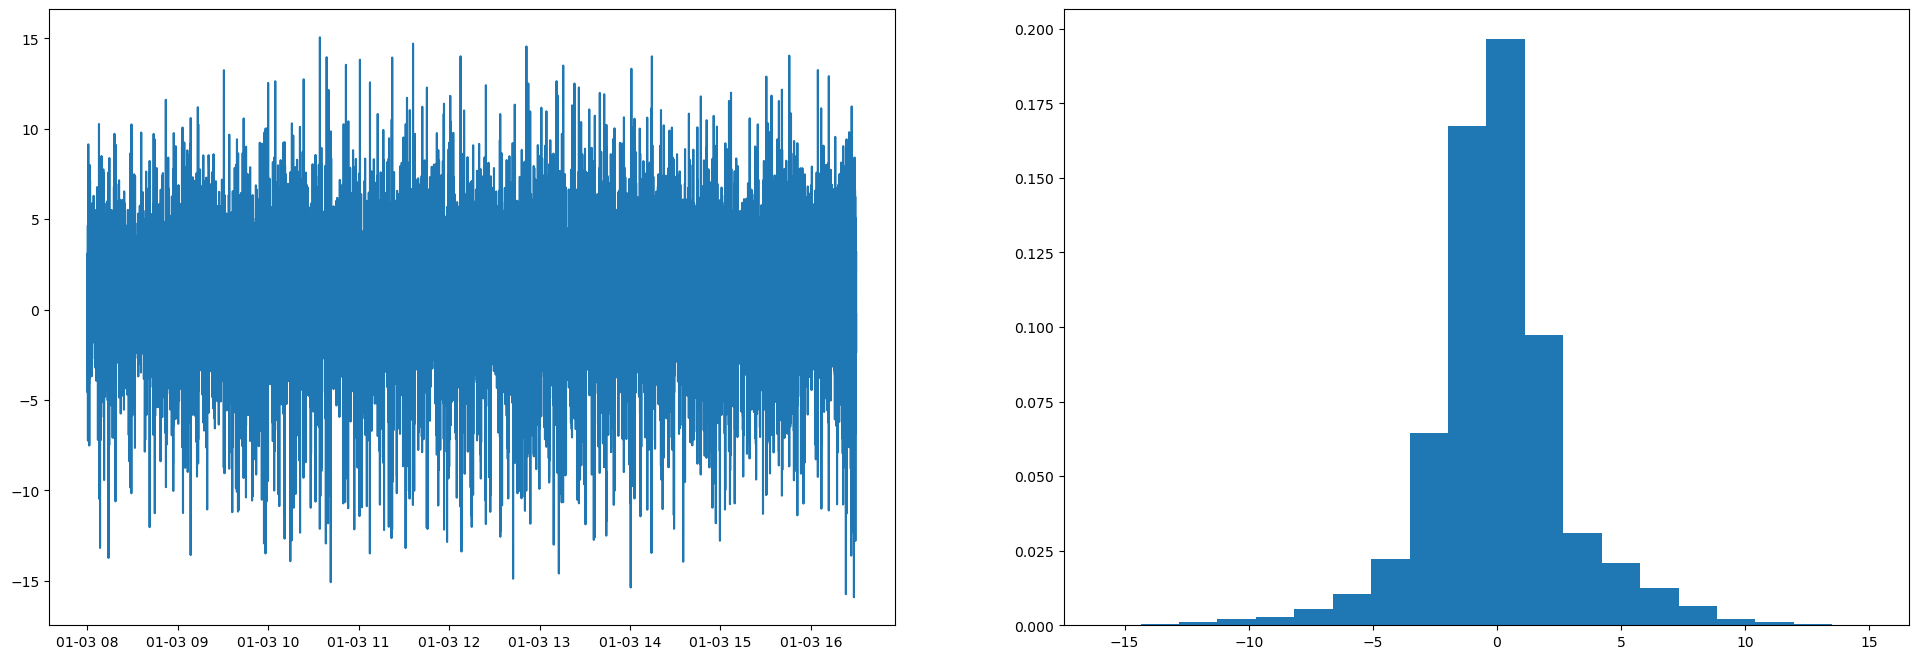

In [24]:
residuals2 = pd.DataFrame(result2.resid)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(residuals2[1:])
ax2.hist(residuals2[1:], density=True, bins=20)

Basic indicator using difference in price predicted

(array([0.00026911, 0.00144052, 0.00528718, 0.02708494, 0.23676765,
        0.10406569, 0.02719575, 0.0078358 , 0.00140886, 0.00033243]),
 array([-11.96267082,  -9.53364644,  -7.10462206,  -4.67559768,
         -2.2465733 ,   0.18245108,   2.61147546,   5.04049984,
          7.46952422,   9.8985486 ,  12.32757298]),
 <BarContainer object of 10 artists>)

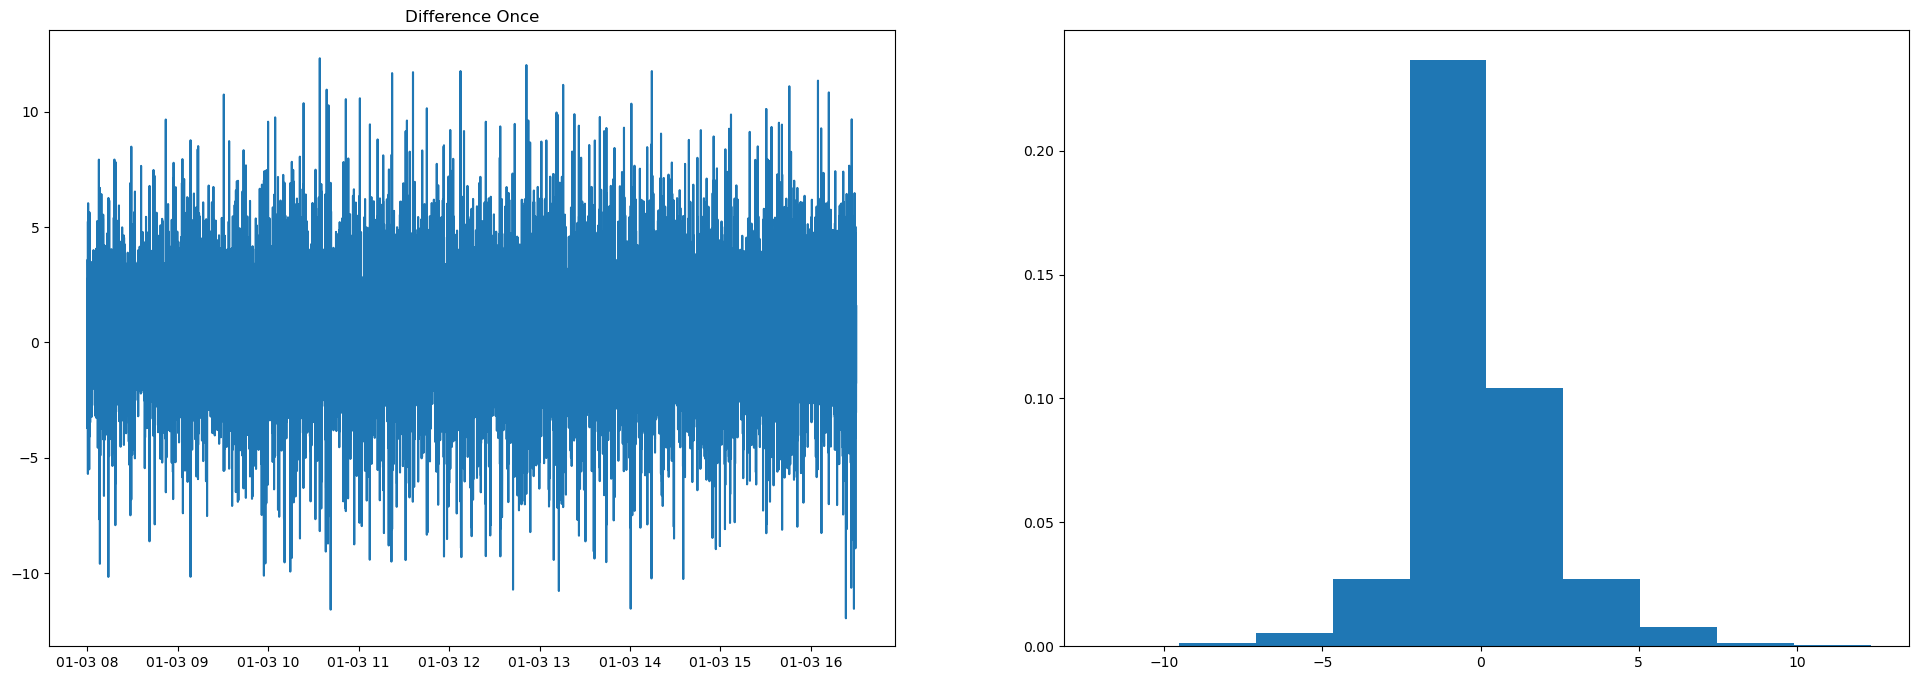

In [25]:
diff2 = pred2.diff().dropna()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(diff2[1:])
ax1.set_title('Difference Once')
ax2.hist(diff2[1:], density=True)

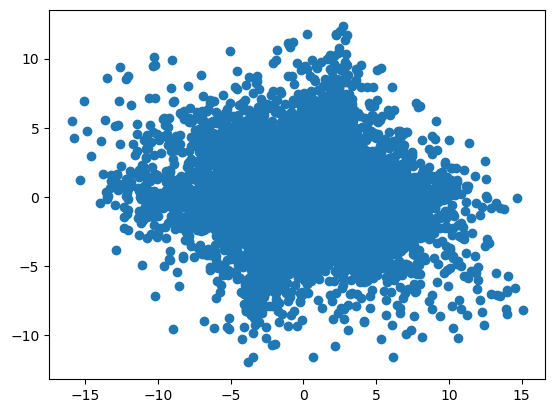

In [26]:
plt.scatter(residuals2[2:], diff2[1:])

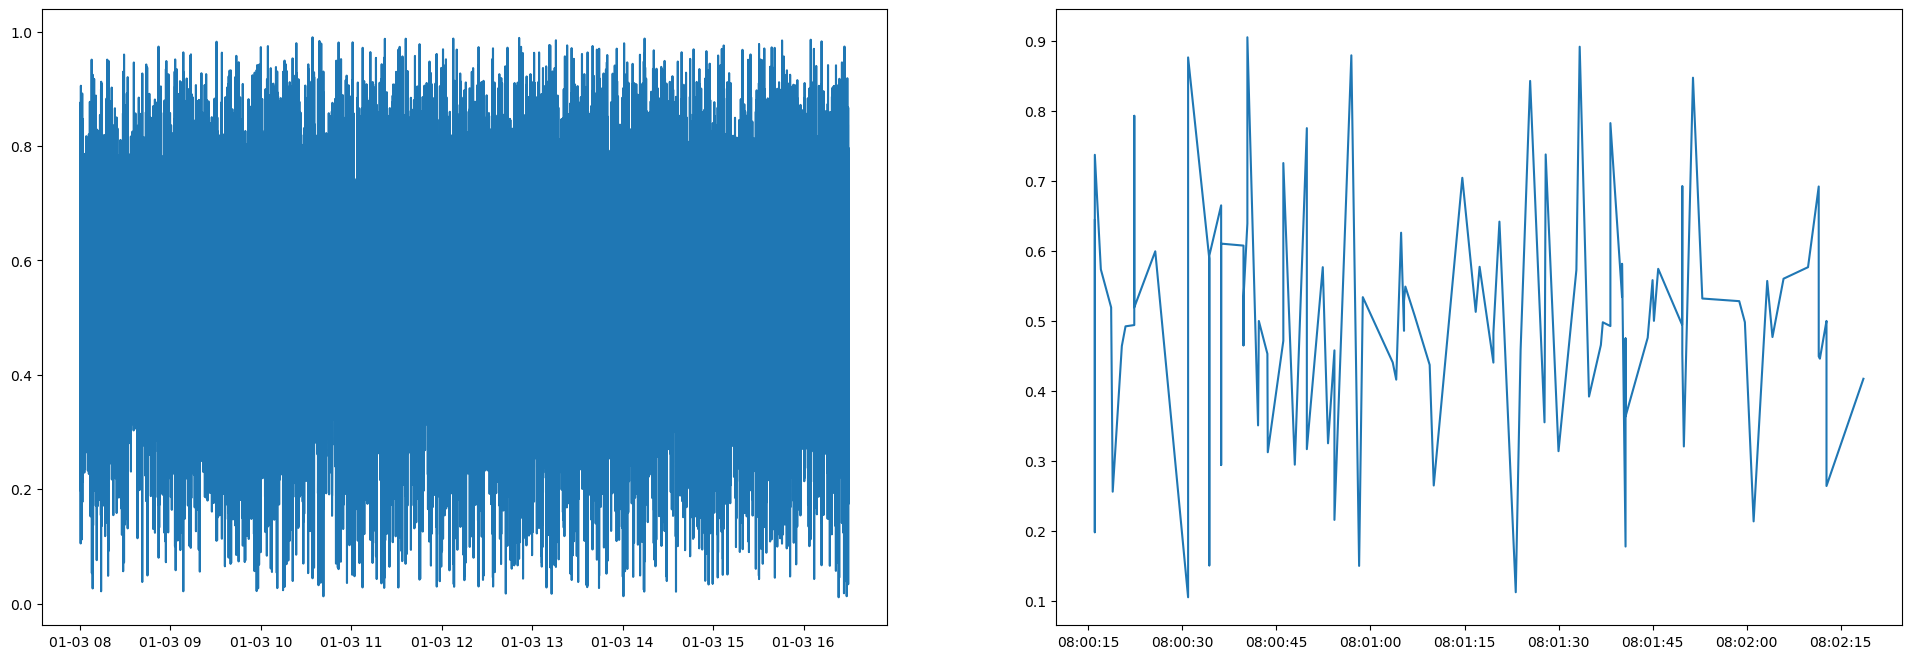

In [27]:
# pass differences through an activation function to get in 0-1 range for buy and sell signals - above 0.5 buy, below 0.5 sell
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# normalise distribtion to normal 
diff2_norm = (diff2 - diff2.mean()) / diff2.std()

singal_diff2 = sigmoid(diff2_norm)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))
ax1.plot(singal_diff2[1:])
ax2.plot(singal_diff2[1:100])

0.6435327591510305


<AxesSubplot:xlabel='combined_time'>

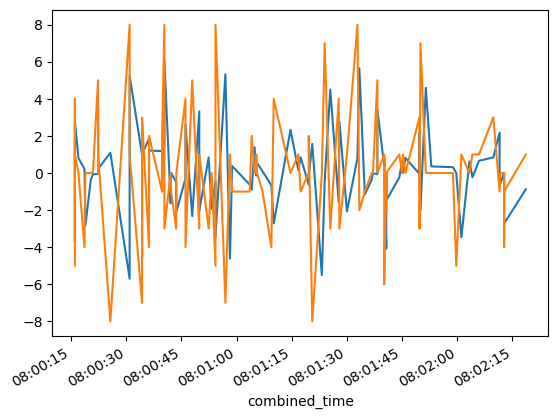

In [39]:
# check how many times signal has correctly predicted movement of actual price

# get actual price movement
actual_diff2 = tape2['Price'].diff().dropna()

correct = (diff2*actual_diff2 )>= 0

print(correct.sum()/len(correct))

diff2[1:100].plot()  
actual_diff2[1:100].plot()

Use the model to make out of sample predictions

In [83]:
model = ARIMA(tape2['Price'][:20000], order=(4,1,4))
result3 = model.fit()

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [84]:
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                20000
Model:                 ARIMA(4, 1, 4)   Log Likelihood              -49008.675
Date:                Thu, 01 Feb 2024   AIC                          98035.350
Time:                        11:58:38   BIC                          98106.481
Sample:                             0   HQIC                         98058.622
                              - 20000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5268      1.486     -0.355      0.723      -3.439       2.386
ar.L2          0.8138      0.816      0.997      0.319      -0.785       2.413
ar.L3          0.5113      1.243      0.412      0.681      -1.924       2.947
ar.L4         -0.1579      0.302     -0.523      0.601      -0.749       0.433
ma.L1          0.1950      1.486      0.131      0.896      -2.717       3.107
ma.L2         -1.1248      1.174     -0.958      0.338      -3.426       1.177
ma.L3         -0.3912      1.419     -0.276      0.783      -3.173       2.391
ma.L4          0.3367      0.618      0.545      0.586      -0.874       1.548
sigma2         7.8707      0.053    147.567      0.000       7.766       7.975
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9169.75
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Text(0.5, 1.0, 'ARIMA(4,1,6) Predictions for first 100 time stamps of Tape 1')

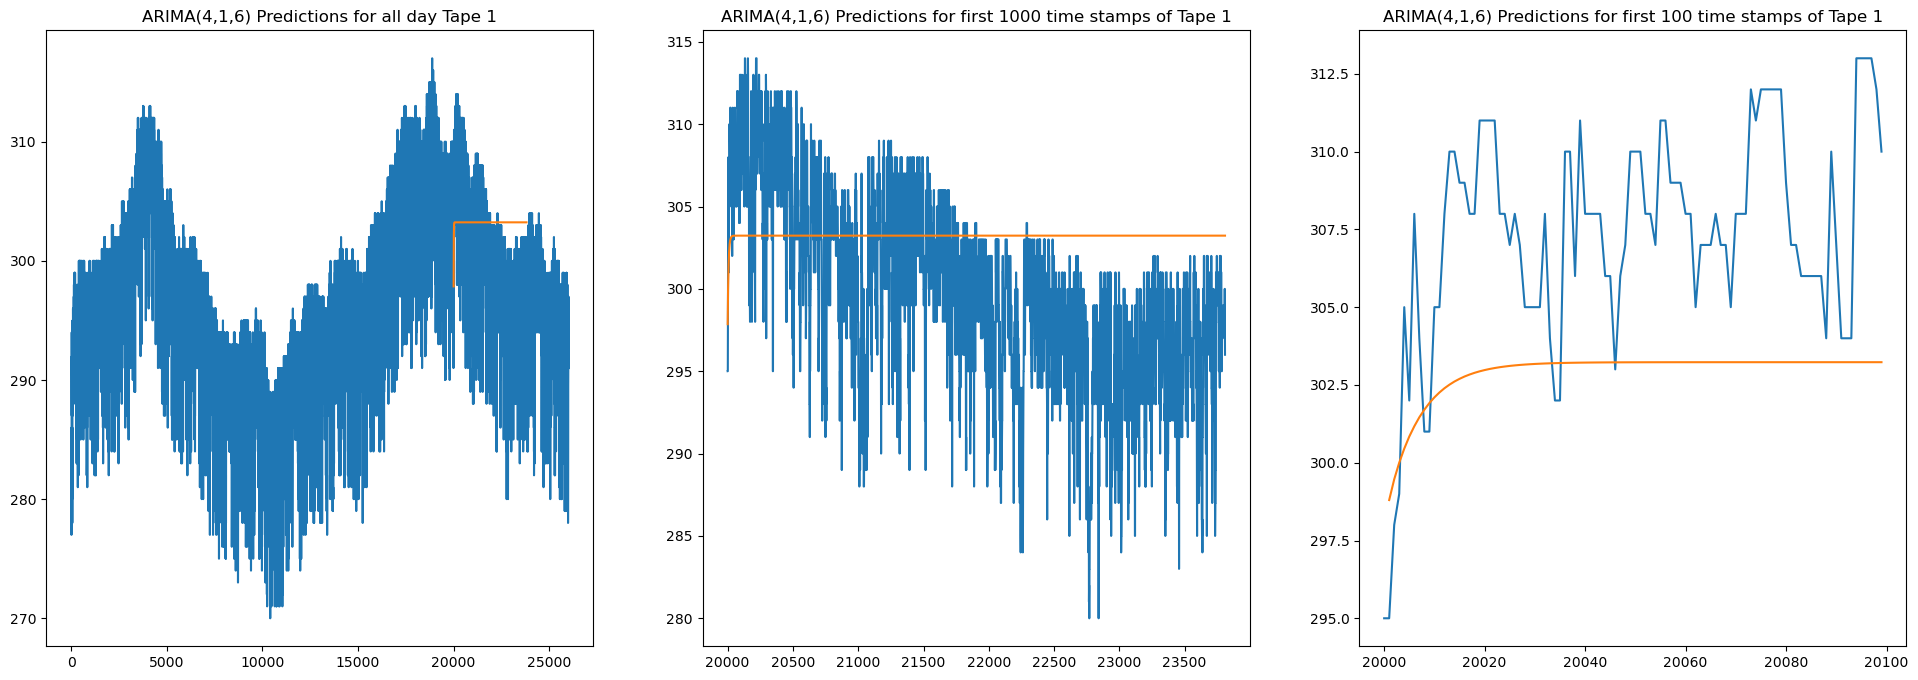

In [85]:
pred2 = result3.forecast(steps = 3810)
forecast_range = np.arange(20000,23810)
total_range = np.arange(0,26009)

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,8))

ax1.plot(total_range,tape2['Price'])
ax1.plot(forecast_range,pred2)
ax1.set_title('ARIMA(4,1,6) Predictions for all day Tape 2')

ax2.plot(forecast_range,tape2['Price'][20000:23810])
ax2.plot(forecast_range,pred2)
ax2.set_title('ARIMA(4,1,6) Predictions for first 1000 time stamps of Tape 2')

ax3.plot(np.arange(20000,20100),tape2['Price'][20000:20100])
ax3.plot(pred2[1:100]) 
ax3.set_title('ARIMA(4,1,6) Predictions for first 100 time stamps of Tape 2')